In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Train Phase transformations
# train_transforms = transforms.Compose([
#                                       A.ShiftScaleRotate(shift_limit = 0.05, p = 0.5),
#                                       A.HorizontalFlip(p=0.5),
#                                       A.CoarseDropout(max_holes=1, max_height=16, max_width=16,
#                                       min_holes=1, min_height=16, min_width=16,
#                                       fill_value=(0.4914, 0.4822, 0.4465),
#                                       mask_fill_value=None),
#                                        transforms.ToTensor(),
#                                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#                                        ])
albu_transforms = A.Compose([
    A.Normalize(mean=(0.4914, 0.4822, 0.4465), std= (0.2023, 0.1994, 0.2010)),
    A.ShiftScaleRotate(shift_limit=0.05, p=0.3),
    A.HorizontalFlip(p=0.5),
    A.CoarseDropout(max_holes=1, max_height=16, max_width=16,
                    min_holes=1, min_height=16, min_width=16,
                    fill_value=(0.4914, 0.4822, 0.4465),
                    mask_fill_value=None),
    A.Resize(32, 32),
    ToTensorV2(),
])
def albu_transform(image):
    # Convert PIL image to numpy array
    image_np = np.array(image)
    # Apply Albumentations transforms
    transformed = albu_transforms(image=image_np)
    return transformed['image']

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [3]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=albu_transform)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:13<00:00, 12815094.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


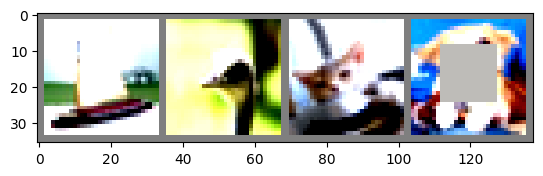

ship  bird  cat   dog  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [6]:
# !pip install torchsummary

In [7]:
#this is depthwise and dilated
import torch.nn.functional as F
from torchsummary import summary

dropout_value = 0.02
group_value = 4
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential( #32
            nn.Conv2d(3, 64, 3, padding=1, bias=False),
             nn.ReLU(),
             nn.BatchNorm2d(64),
             nn.Dropout(dropout_value)

        )
        self.conv2 = nn.Sequential( #32
            nn.Conv2d(64, 64, 3, padding=1, groups = 64, bias=False),
            nn.Conv2d(64, 128, 1, padding=0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value)
        )
        #tb
        self.conv3 = nn.Sequential( #16
            nn.Conv2d(128,64, 3, padding=2, bias=False, stride = 2, dilation = 2), #adjusting padding and stride to incorporate dilation with no size increase
        )
        ##BLOCK2
        self.conv4 = nn.Sequential( #16
            nn.Conv2d(64, 64, 3, padding=1,groups = 64, bias=False),
            nn.Conv2d(64, 128, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
        )
        self.conv5 = nn.Sequential( #16
            nn.Conv2d(128,128, 3, padding=1, groups = 128, bias=False),
            nn.Conv2d(128, 128, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(dropout_value),
        )
        #tb
        self.conv6 = nn.Sequential( #8
            nn.Conv2d(128, 64, 3, padding=2, bias=False, stride= 2, dilation = 2), #keeping the padding 'same'
        )

        ##BLOCK3
        self.conv7 = nn.Sequential( #8
            nn.Conv2d(64, 64, 3, padding=1,groups = 64, bias=False),
            nn.Conv2d(64, 64, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )
        self.conv8 = nn.Sequential(#8
            nn.Conv2d(64, 64, 3, padding=1,groups = 64, bias=False),
            nn.Conv2d(64, 64, 1, padding = 0, bias = False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )
        self.conv9 = nn.Sequential( #4
            nn.Conv2d(64, 64, 3, padding=1, groups = 64, bias=False, stride = 2),
            nn.Conv2d(64, 32, 1, padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32)
,
nn.Dropout(dropout_value)        )
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )

        self.conv10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.conv9(x)
        x = self.gap(x)
        x = self.conv10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]             576
            Conv2d-6          [-1, 128, 32, 32]           8,192
              ReLU-7          [-1, 128, 32, 32]               0
       BatchNorm2d-8          [-1, 128, 32, 32]             256
           Dropout-9          [-1, 128, 32, 32]               0
           Conv2d-10           [-1, 64, 16, 16]          73,728
           Conv2d-11           [-1, 64, 16, 16]             576
           Conv2d-12          [-1, 128, 16, 16]           8,192
             ReLU-13          [-1, 128, 16, 16]               0
      BatchNorm2d-14          [-1,

In [8]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    misclassified_images = []  # List to store misclassified images and labels
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1)  # Remove keepdim=True; now shape: [batch_size]
            correct += pred.eq(target).sum().item()

            # Find misclassified indices
            misclassified_idxs = (pred != target).nonzero(as_tuple=False).squeeze()
            for idx in misclassified_idxs:
                if len(misclassified_images) < 10:  # Collect only 10 images
                    img = data[idx].cpu()
                    actual_label = target[idx].item()
                    predicted_label = pred[idx].item()
                    misclassified_images.append((img, predicted_label, actual_label))
                else:
                    break

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    Accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))
    return misclassified_images, Accuracy


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'max', patience = 20)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    # test(model, device, test_loader)
    misclassified_images, Accuracy = test(model, device, test_loader)
    scheduler.step(Accuracy)


EPOCH: 0


Loss=1.710497498512268 Batch_id=97 Accuracy=28.51: 100%|██████████| 98/98 [00:15<00:00,  6.34it/s]



Test set: Average loss: 1.6225, Accuracy: 4032/10000 (40.32%)

EPOCH: 1


Loss=1.5795221328735352 Batch_id=97 Accuracy=41.91: 100%|██████████| 98/98 [00:14<00:00,  6.65it/s]



Test set: Average loss: 1.3875, Accuracy: 4974/10000 (49.74%)

EPOCH: 2


Loss=1.3346853256225586 Batch_id=97 Accuracy=48.12: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 1.2457, Accuracy: 5475/10000 (54.75%)

EPOCH: 3


Loss=1.316941261291504 Batch_id=97 Accuracy=52.16: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 1.1666, Accuracy: 5842/10000 (58.42%)

EPOCH: 4


Loss=1.1804143190383911 Batch_id=97 Accuracy=54.98: 100%|██████████| 98/98 [00:14<00:00,  6.87it/s]



Test set: Average loss: 1.1661, Accuracy: 5854/10000 (58.54%)

EPOCH: 5


Loss=1.1877511739730835 Batch_id=97 Accuracy=57.37: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]



Test set: Average loss: 1.0116, Accuracy: 6336/10000 (63.36%)

EPOCH: 6


Loss=1.1549593210220337 Batch_id=97 Accuracy=59.49: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.9577, Accuracy: 6592/10000 (65.92%)

EPOCH: 7


Loss=1.0202550888061523 Batch_id=97 Accuracy=61.00: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.9115, Accuracy: 6775/10000 (67.75%)

EPOCH: 8


Loss=1.0238527059555054 Batch_id=97 Accuracy=62.55: 100%|██████████| 98/98 [00:14<00:00,  6.64it/s]



Test set: Average loss: 0.9267, Accuracy: 6726/10000 (67.26%)

EPOCH: 9


Loss=1.0932703018188477 Batch_id=97 Accuracy=63.84: 100%|██████████| 98/98 [00:14<00:00,  6.69it/s]



Test set: Average loss: 0.8508, Accuracy: 6948/10000 (69.48%)

EPOCH: 10


Loss=0.9857684373855591 Batch_id=97 Accuracy=65.02: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.9529, Accuracy: 6580/10000 (65.80%)

EPOCH: 11


Loss=1.0785623788833618 Batch_id=97 Accuracy=65.71: 100%|██████████| 98/98 [00:14<00:00,  6.61it/s]



Test set: Average loss: 0.7835, Accuracy: 7240/10000 (72.40%)

EPOCH: 12


Loss=0.9157437682151794 Batch_id=97 Accuracy=67.05: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 0.7493, Accuracy: 7376/10000 (73.76%)

EPOCH: 13


Loss=0.8634310960769653 Batch_id=97 Accuracy=67.75: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.7489, Accuracy: 7382/10000 (73.82%)

EPOCH: 14


Loss=0.9269131422042847 Batch_id=97 Accuracy=68.06: 100%|██████████| 98/98 [00:14<00:00,  6.72it/s]



Test set: Average loss: 0.7332, Accuracy: 7440/10000 (74.40%)

EPOCH: 15


Loss=0.8698310852050781 Batch_id=97 Accuracy=69.01: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]



Test set: Average loss: 0.7161, Accuracy: 7477/10000 (74.77%)

EPOCH: 16


Loss=0.8584109544754028 Batch_id=97 Accuracy=69.83: 100%|██████████| 98/98 [00:14<00:00,  6.79it/s]



Test set: Average loss: 0.7264, Accuracy: 7502/10000 (75.02%)

EPOCH: 17


Loss=0.8440501689910889 Batch_id=97 Accuracy=70.32: 100%|██████████| 98/98 [00:14<00:00,  6.78it/s]



Test set: Average loss: 0.6660, Accuracy: 7710/10000 (77.10%)

EPOCH: 18


Loss=0.844784140586853 Batch_id=97 Accuracy=71.13: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]



Test set: Average loss: 0.6736, Accuracy: 7652/10000 (76.52%)

EPOCH: 19


Loss=0.7097283601760864 Batch_id=97 Accuracy=71.35: 100%|██████████| 98/98 [00:14<00:00,  6.70it/s]



Test set: Average loss: 0.6724, Accuracy: 7672/10000 (76.72%)

EPOCH: 20


Loss=0.7534453868865967 Batch_id=97 Accuracy=72.01: 100%|██████████| 98/98 [00:14<00:00,  6.63it/s]



Test set: Average loss: 0.6458, Accuracy: 7756/10000 (77.56%)

EPOCH: 21


Loss=0.7332770824432373 Batch_id=97 Accuracy=72.02: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.6422, Accuracy: 7771/10000 (77.71%)

EPOCH: 22


Loss=0.6645321846008301 Batch_id=97 Accuracy=72.99: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.6308, Accuracy: 7792/10000 (77.92%)

EPOCH: 23


Loss=0.7749243378639221 Batch_id=97 Accuracy=72.86: 100%|██████████| 98/98 [00:14<00:00,  6.85it/s]



Test set: Average loss: 0.6298, Accuracy: 7842/10000 (78.42%)

EPOCH: 24


Loss=0.7429274320602417 Batch_id=97 Accuracy=73.60: 100%|██████████| 98/98 [00:14<00:00,  6.84it/s]



Test set: Average loss: 0.6369, Accuracy: 7819/10000 (78.19%)

EPOCH: 25


Loss=0.6622611880302429 Batch_id=97 Accuracy=74.05: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 0.5867, Accuracy: 7996/10000 (79.96%)

EPOCH: 26


Loss=0.7095470428466797 Batch_id=97 Accuracy=74.30: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]



Test set: Average loss: 0.6069, Accuracy: 7900/10000 (79.00%)

EPOCH: 27


Loss=0.7355461716651917 Batch_id=97 Accuracy=74.37: 100%|██████████| 98/98 [00:15<00:00,  6.42it/s]



Test set: Average loss: 0.5674, Accuracy: 8035/10000 (80.35%)

EPOCH: 28


Loss=0.7495827674865723 Batch_id=97 Accuracy=74.95: 100%|██████████| 98/98 [00:20<00:00,  4.88it/s]



Test set: Average loss: 0.5848, Accuracy: 7982/10000 (79.82%)

EPOCH: 29


Loss=0.7027510404586792 Batch_id=97 Accuracy=75.10: 100%|██████████| 98/98 [00:14<00:00,  6.80it/s]



Test set: Average loss: 0.5741, Accuracy: 8094/10000 (80.94%)

EPOCH: 30


Loss=0.6890742182731628 Batch_id=97 Accuracy=75.19: 100%|██████████| 98/98 [00:14<00:00,  6.62it/s]



Test set: Average loss: 0.5818, Accuracy: 7975/10000 (79.75%)

EPOCH: 31


Loss=0.6764737963676453 Batch_id=97 Accuracy=75.59: 100%|██████████| 98/98 [00:14<00:00,  6.88it/s]



Test set: Average loss: 0.5790, Accuracy: 8021/10000 (80.21%)

EPOCH: 32


Loss=0.5971915125846863 Batch_id=97 Accuracy=75.88: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 0.5481, Accuracy: 8140/10000 (81.40%)

EPOCH: 33


Loss=0.7487209439277649 Batch_id=97 Accuracy=76.00: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 0.5357, Accuracy: 8166/10000 (81.66%)

EPOCH: 34


Loss=0.6835412383079529 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]



Test set: Average loss: 0.5439, Accuracy: 8128/10000 (81.28%)

EPOCH: 35


Loss=0.6589550971984863 Batch_id=97 Accuracy=76.50: 100%|██████████| 98/98 [00:15<00:00,  6.32it/s]



Test set: Average loss: 0.5415, Accuracy: 8150/10000 (81.50%)

EPOCH: 36


Loss=0.8055596351623535 Batch_id=97 Accuracy=76.82: 100%|██████████| 98/98 [00:14<00:00,  6.66it/s]



Test set: Average loss: 0.5227, Accuracy: 8234/10000 (82.34%)

EPOCH: 37


Loss=0.676594078540802 Batch_id=97 Accuracy=76.91: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.5149, Accuracy: 8248/10000 (82.48%)

EPOCH: 38


Loss=0.6602272391319275 Batch_id=97 Accuracy=77.44: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.5117, Accuracy: 8245/10000 (82.45%)

EPOCH: 39


Loss=0.7578785419464111 Batch_id=97 Accuracy=77.10: 100%|██████████| 98/98 [00:14<00:00,  6.60it/s]



Test set: Average loss: 0.5333, Accuracy: 8160/10000 (81.60%)

EPOCH: 40


Loss=0.6496258974075317 Batch_id=97 Accuracy=77.69: 100%|██████████| 98/98 [00:14<00:00,  6.77it/s]



Test set: Average loss: 0.5134, Accuracy: 8246/10000 (82.46%)

EPOCH: 41


Loss=0.5773354172706604 Batch_id=97 Accuracy=78.08: 100%|██████████| 98/98 [00:14<00:00,  6.75it/s]



Test set: Average loss: 0.5074, Accuracy: 8289/10000 (82.89%)

EPOCH: 42


Loss=0.609562873840332 Batch_id=97 Accuracy=77.83: 100%|██████████| 98/98 [00:14<00:00,  6.56it/s]



Test set: Average loss: 0.4997, Accuracy: 8264/10000 (82.64%)

EPOCH: 43


Loss=0.5835670828819275 Batch_id=97 Accuracy=78.21: 100%|██████████| 98/98 [00:14<00:00,  6.96it/s]



Test set: Average loss: 0.5159, Accuracy: 8250/10000 (82.50%)

EPOCH: 44


Loss=0.571167528629303 Batch_id=97 Accuracy=78.01: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.5133, Accuracy: 8267/10000 (82.67%)

EPOCH: 45


Loss=0.5809704065322876 Batch_id=97 Accuracy=78.70: 100%|██████████| 98/98 [00:14<00:00,  6.74it/s]



Test set: Average loss: 0.5124, Accuracy: 8257/10000 (82.57%)

EPOCH: 46


Loss=0.6004183888435364 Batch_id=97 Accuracy=78.94: 100%|██████████| 98/98 [00:15<00:00,  6.49it/s]



Test set: Average loss: 0.5142, Accuracy: 8250/10000 (82.50%)

EPOCH: 47


Loss=0.5769177079200745 Batch_id=97 Accuracy=78.91: 100%|██████████| 98/98 [00:14<00:00,  6.73it/s]



Test set: Average loss: 0.5112, Accuracy: 8275/10000 (82.75%)

EPOCH: 48


Loss=0.6559115648269653 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [00:14<00:00,  6.67it/s]



Test set: Average loss: 0.4891, Accuracy: 8364/10000 (83.64%)

EPOCH: 49


Loss=0.6719439625740051 Batch_id=97 Accuracy=79.07: 100%|██████████| 98/98 [00:14<00:00,  6.82it/s]



Test set: Average loss: 0.4974, Accuracy: 8377/10000 (83.77%)



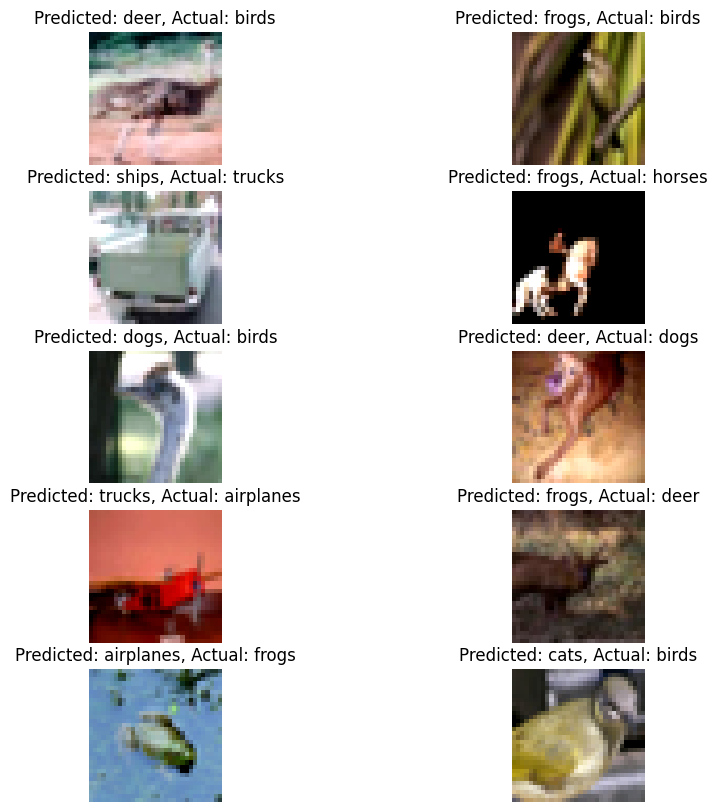

In [ ]:
import matplotlib.pyplot as plt

def visualize_misclassified_images(misclassified_images):
    classes = ['airplanes', 'cars', 'birds', 'cats', 'deer', 'dogs', 'frogs', 'horses', 'ships', 'trucks']
    plt.figure(figsize=(10, 10)) #original images were 32x32
    for i, (image, pred, actual) in enumerate(misclassified_images[:10]):
        image = image.numpy().transpose(1, 2, 0)  # Convert to (height, width, channel)
        mean = [0.4914, 0.4822, 0.4465] #3 values for 2 channels, RGB
        std = [0.247, 0.243, 0.261]
        image = image * std + mean  # Undo normalization
        image = np.clip(image, 0, 1)  # Clip values to valid range

        plt.subplot(5, 2, i+1)
        plt.imshow(image)

        plt.title(f"Predicted: {classes[pred]}, Actual: {classes[actual]}")
        plt.axis('off')
    plt.show()

visualize_misclassified_images(misclassified_images)


In [ ]:
model

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [ ]:
t = [train_items.item() for train_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

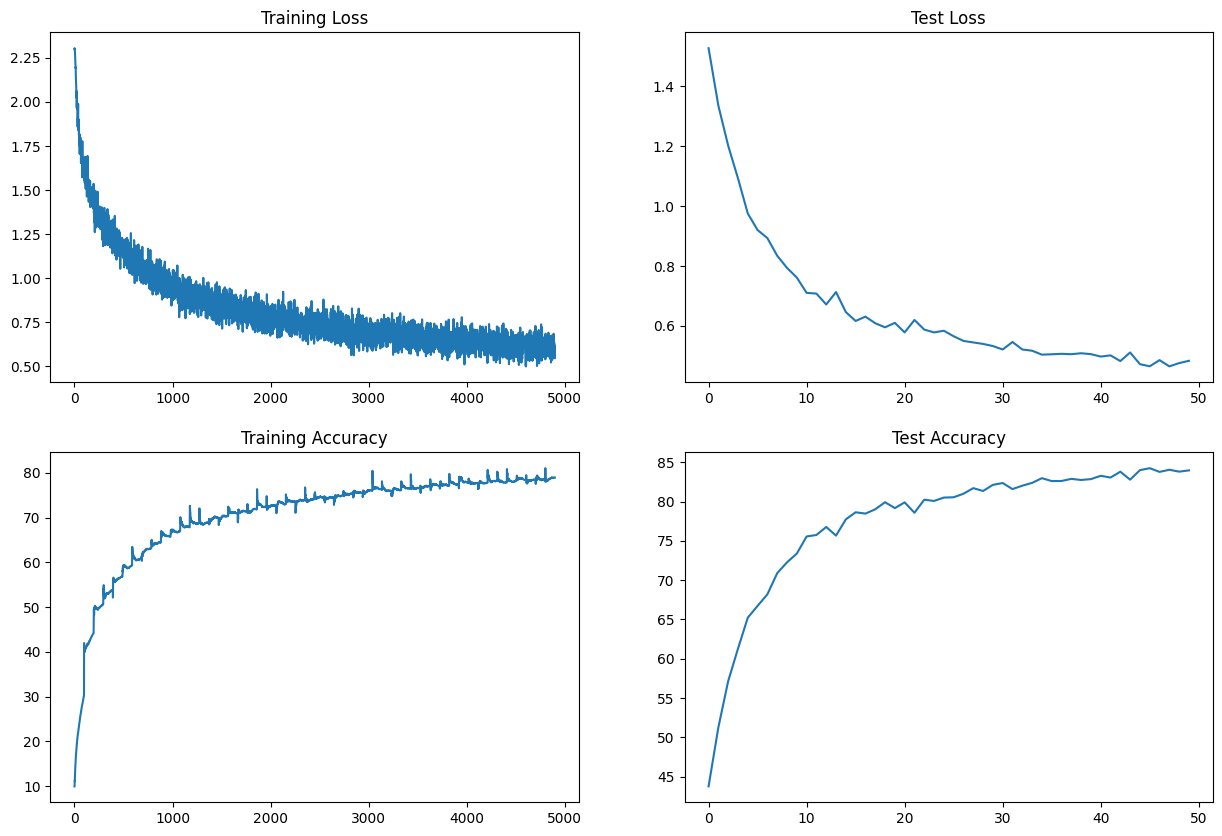

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 10
conv_layers


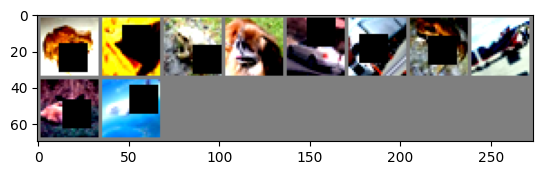

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

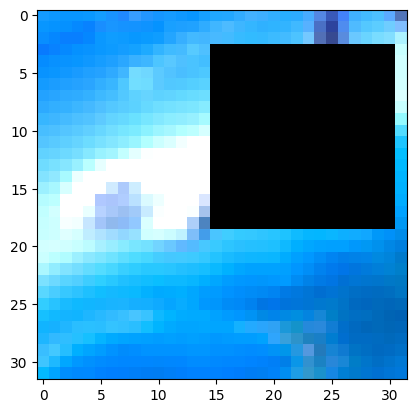

In [ ]:
image = images[9]
imshow(image)

In [ ]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

10
torch.Size([1, 64, 32, 32])
torch.Size([1, 64, 32, 32])
torch.Size([1, 32, 36, 36])
torch.Size([1, 64, 36, 36])
torch.Size([1, 64, 36, 36])
torch.Size([1, 32, 40, 40])
torch.Size([1, 64, 40, 40])
torch.Size([1, 64, 40, 40])
torch.Size([1, 32, 44, 44])
torch.Size([1, 10, 44, 44])


In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(32, 32)
(32, 32)
(36, 36)
(36, 36)
(36, 36)
(40, 40)
(40, 40)
(40, 40)
(44, 44)
(44, 44)


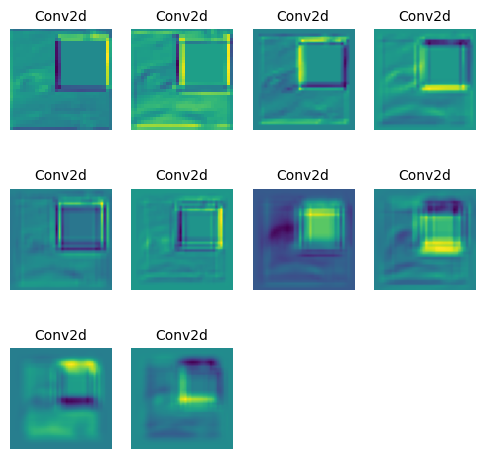

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

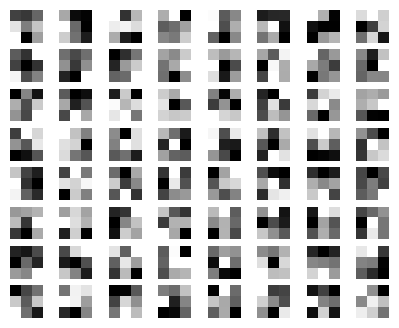

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()